# Social Representations and Boundaries of Humor: A focus on Gender roles

## Research questions: 

1) How are men and women depicted in New Yorker cartoons and captions, and do these depictions reflect traditional gender roles or stereotypes?

2) How does audience response (e.g., votes or winning captions) relate to gendered content—do captions about one gender receive more positive attention, and does this reinforce or challenge stereotypes?

## Structure:

### 0. Method to detect gender

Detect gendered references in captions/descriptions and assign a gender to each of them (male, female, both, neutral). 

*Method*: Found two gender lists that contains gendered word. I wanted a longer list so I manually augmented it with universal gendered word and contextual gender markers. Then I added words based on what words are actually on the dataset.

### 1. General distributions

1) Overall presence of gender in captions and image descriptions (barplot)

2) top gendered words -> BOW matrix (histogram)

### 2. How are men/women depicted in the captions

1) Find the top words associated with each gender (wordclouds)

2) Find topic related to man and woman (topic detection)

3) Are men/women seen positively/negatively? (Does it evolve over time?) (sentiment analysis)


### 3. Audience response to gender related captions ?

1. Are captions mentionning gender more funny ? (funnyness score + t-test: $H_0$: There are no difference in funiness between gendered caption and non gendered captions. If refuted: $H_0$: There are no difference in funiness between male gendered caption and female gendered caption. *hope it's refuted*)

2. Does it change over time ?

## Initialisation of the root path

In [1]:
from pathlib import Path
import sys

def warning1(text): print("WARNING!!! ", text)
ACTIVATE_PRINTS = False

# Get correct root path
try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if all((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

if ACTIVATE_PRINTS: print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

print(root)

d:\GitHub\ada-2025-project-adacore42


## Imports

In [60]:
# working librairies
import os
import pickle
import csv

sys.path.append(os.path.abspath(".."))

# utils
from src.utils.general_utils import *

# class with functions
from src.models.gender_analysis import GenderAnalysis

# basics
import pandas as pd
import numpy as np

# other
from collections import Counter

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import plotly.express as px

# text processing libraries
import nltk
import spacy
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Statistical testing
from scipy.stats import mannwhitneyu

In [61]:
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(DATA_PREPARATION_PY_PATH.resolve()) #If works: ...../ADAcore42/src/data/DataPreparation.py

D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\src\data\DataPreparation.py


In [62]:
%run {DATA_PREPARATION_PY_PATH.resolve()}

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19
4,"If you can meditate here, you can meditate any...",1.617647,0.126764,34,18,11,5,1.73
5,"Sorry for the inconvenience, I probably should...",1.593750,0.117598,32,16,13,3,1.69
6,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,1.52
7,I've decided to take it lying down.,1.593750,0.133647,32,18,9,5,1.26
8,You probably know my column: Man on the Street.,1.538462,0.126865,26,14,10,2,0.89
9,I should have jumped from a higher floor.,1.541667,0.134315,24,13,9,2,0.87


## Loading the data



In [64]:
ga = GenderAnalysis()

In [65]:
data = ga.load_pickle(root / STORED_DATAPREP_PKL_PATH)

In [66]:
# Extract the objects in the pickle

# dataA est une liste de DataFrames pandas (ou un objet similaire, comme un dictionnaire de DataFrames). Chaque élément de la liste contient un DataFrame avec 7 colonnes et un nombre variable de lignes.
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

In [67]:
dataA_removed, dataC_removed = drop_NaN(dataA, dataC)

In [68]:
print(f"Length dataA: {len(dataA_removed)}\nShape dataC: {dataC_removed.shape}")

Length dataA: 240
Shape dataC: (240, 9)


In [69]:
dataA_removed[0].head()

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19
4,"If you can meditate here, you can meditate any...",1.617647,0.126764,34,18,11,5,1.73


In [71]:
dataC_removed.head()

,num_captions,num_votes,image_locations,image_descriptions,image_uncanny_descriptions,entities,questions,contest_id,date
0,3905.0,41185.0,[the street],[A man is relaxing on a city street. Others ar...,[A man is just laying in the middle of the sid...,[https://en.wikipedia.org/wiki/Bystander_effec...,[Why is he laying there?],510,NaT
1,3325.0,28205.0,"[the front hard, a residential walkway]",[A man in a winter coat and cap is looking at ...,[It's unusual to see someone holding a snow sh...,"[https://en.wikipedia.org/wiki/Snowball_fight,...",[Is the man overly small or the shovel overly ...,511,NaT
2,4399.0,21574.0,"[yoga place, a yoga studio]",[A man and woman are standing facing one anoth...,[Nothing is really out of place in this image....,"[https://en.wikipedia.org/wiki/Rug, https://en...","[Why is the man carrying a huge rug?, Why is t...",512,2016-03-21
3,4141.0,16894.0,"[a workplace, an elevator]",[Three business men are walking down a hall. T...,[A suit case is usually carried by one person ...,[https://en.wikipedia.org/wiki/Worker_cooperat...,[Why is the briefcase big enough for three peo...,513,2016-03-27
4,3951.0,95790.0,[plains],[Some cowboys are riding through the desert. T...,[There are rocking horses in place of real hor...,"[https://en.wikipedia.org/wiki/Rocking_horse, ...",[Why is this chase taking place?],514,2016-04-03


## Step 0: Augment the gendered lists

Include male and female names: asked to chatGPT to produce me a list (based on Social Security Administration data)

Include public figures: asked chatGPT for 50 male and female celebrities

The list can be found in gender_analysis.py

## Step 1: Detect gender

Use gender lexicons, but we need to define them first. 

For P2, I used two small lists with common gendered terms. For P3 I want to extend them based on what what terms are used in the contest!

### In the image description

In [9]:
# detect gender in the cartoon descriptions
dataC0 = dataC_removed.copy(deep=True)
dataC1 = ga.get_metadata(dataC0)

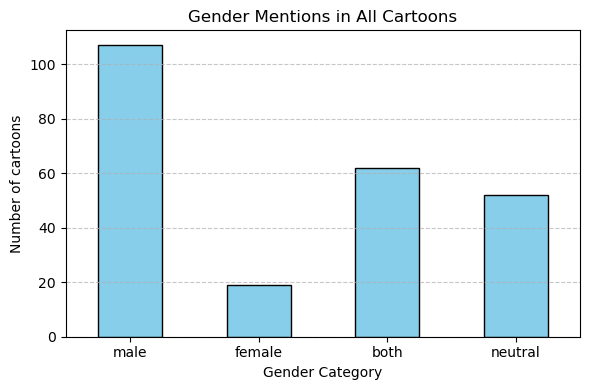

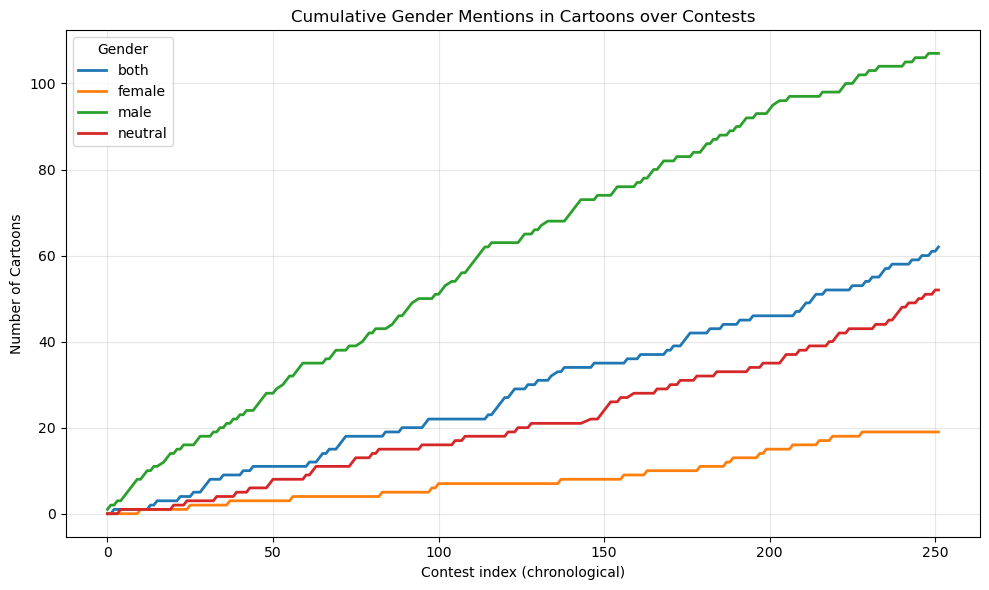

In [10]:
# How often men/women appear in a cartoon ?

# Overall distribution of gender over all the cartoons.
gender_image = dataC1['gender_mention']

# Count frequency
gender_counts = gender_image.value_counts().sort_index()

# Plot Overall counts
ga.plot_overall_counts(
    gender_counts,
    title="Gender Mentions in All Cartoons",
    xlabel="Gender Category",
    ylabel="Number of cartoons"
)

# Evolution over time
df = pd.DataFrame({"contest_index": range(0, len(dataC1)),
                   "gender_mention": dataC1['gender_mention']})

# Count mentions per contest (here each row = one contest)
counts = pd.get_dummies(df["gender_mention"]).cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions(
    counts,
    title="Cumulative Gender Mentions in Cartoons over Contests",
    xlabel="Contest index (chronological)",
    ylabel="Number of Cartoons",
    legend_title="Gender"
)

### In the captions

In [ ]:
# # DON'T RUN THIS AGAIN
# dataTop = ga.get_Top_captions(dataA_removed)

# # Results were saved here: 
# STORED_DATAPREP_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions_1.pkl'
# with open(STORED_DATAPREP_PKL_PATH, "wb") as f:
#     pickle.dump(dataTop, f)

In [ ]:
STORED_DATACAPTION_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions_1.pkl'
data_caption = ga.load_pickle(STORED_DATACAPTION_PKL_PATH)

In [11]:
count = []

for idx, contest in enumerate(data_caption):
    # Count mentions per contest
    gender_counts = (
        contest["gender_mention"]
        .value_counts()
        #.unstack(fill_value=0)
        .reset_index()
    )
    count.append(gender_counts)

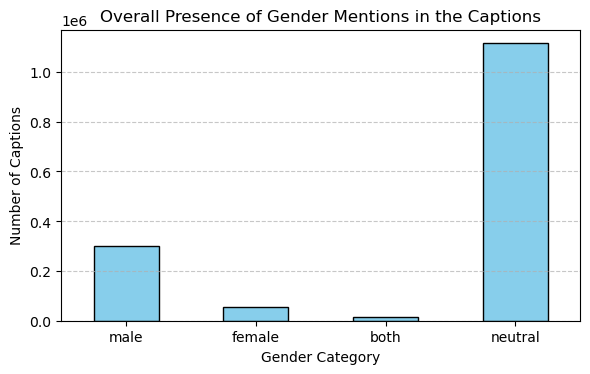

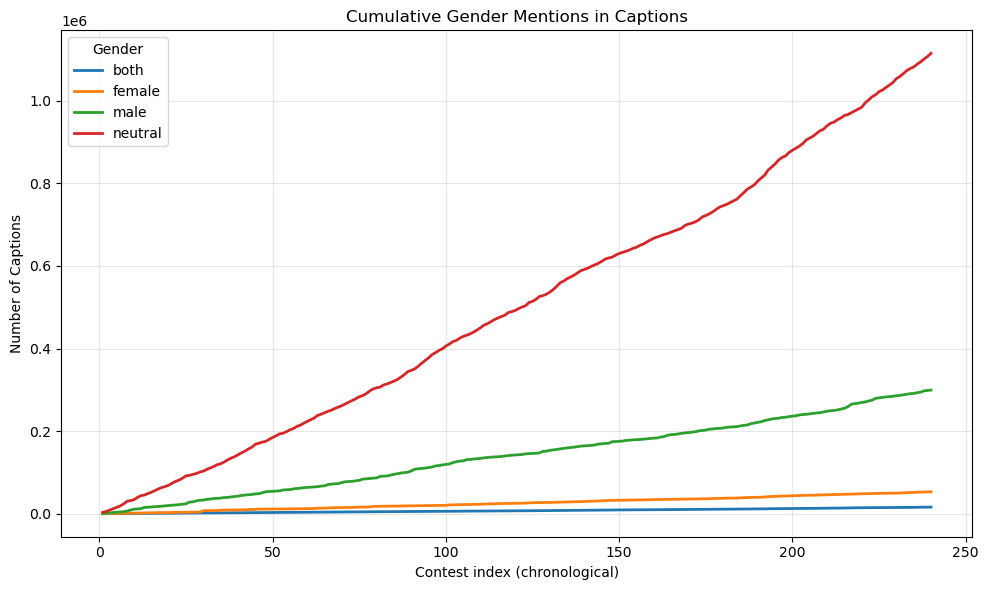

In [12]:
# How often men/women are mentionned in captions

overall_counts, pivoted = ga.distribution_captions(count)

# In the plots I don't show the neutral, because it is a huge number compared
# to the other categories

# Plot Overall counts
ga.plot_overall_counts(
    overall_counts,
    title="Overall Presence of Gender Mentions in the Captions",
    xlabel="Gender Category",
    ylabel="Number of Captions",
    neutral = True
)

# Evolution over time
cumulative = pivoted.cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions(
    cumulative,
    title="Cumulative Gender Mentions in Captions",
    xlabel="Contest index (chronological)",
    ylabel="Number of Captions",
    legend_title="Gender",
    neutral = True
)

## Step 2: How are men/women depicted in the captions ? 

### Verbs and adjectives associated with genders

In [ ]:
# nlp = spacy.load("en_core_web_sm")

# verbs_male = Counter()
# verbs_female = Counter()
# adjs_male = Counter()
# adjs_female = Counter()

# for contest in data_caption:

#     male_caps   = contest.loc[contest['gender_mention'] == 'male',   'caption'].tolist()
#     female_caps = contest.loc[contest['gender_mention'] == 'female', 'caption'].tolist()

#     # process male captions in batch
#     for doc in nlp.pipe(male_caps):
#         for token in doc:
#             if token.pos_ == "VERB":
#                 verbs_male[token.lemma_] += 1
#             elif token.pos_ == "ADJ":
#                 adjs_male[token.lemma_] += 1

#     # process female captions in batch
#     for doc in nlp.pipe(female_caps):
#         for token in doc:
#             if token.pos_ == "VERB":
#                 verbs_female[token.lemma_.lower()] += 1
#             elif token.pos_ == "ADJ":
#                 adjs_female[token.lemma_.lower()] += 1

In [ ]:
# STORED_FREQS_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\freqs_verb_adj.pkl'
# with open(STORED_FREQS_PKL_PATH, "wb") as f:
#     pickle.dump({"verbs_male": verbs_male, "verbs_female": verbs_female, "adjs_male": adjs_male, "adjs_female": adjs_female}, f)

In [24]:
STORED_FREQS_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\freqs_verb_adj.pkl'
data_wordcloud = ga.load_pickle(STORED_FREQS_PKL_PATH)

verbs_male = data_wordcloud['verbs_male']
verbs_female = data_wordcloud['verbs_female']

adjs_male = data_wordcloud['adjs_male']
adjs_female = data_wordcloud['adjs_female']

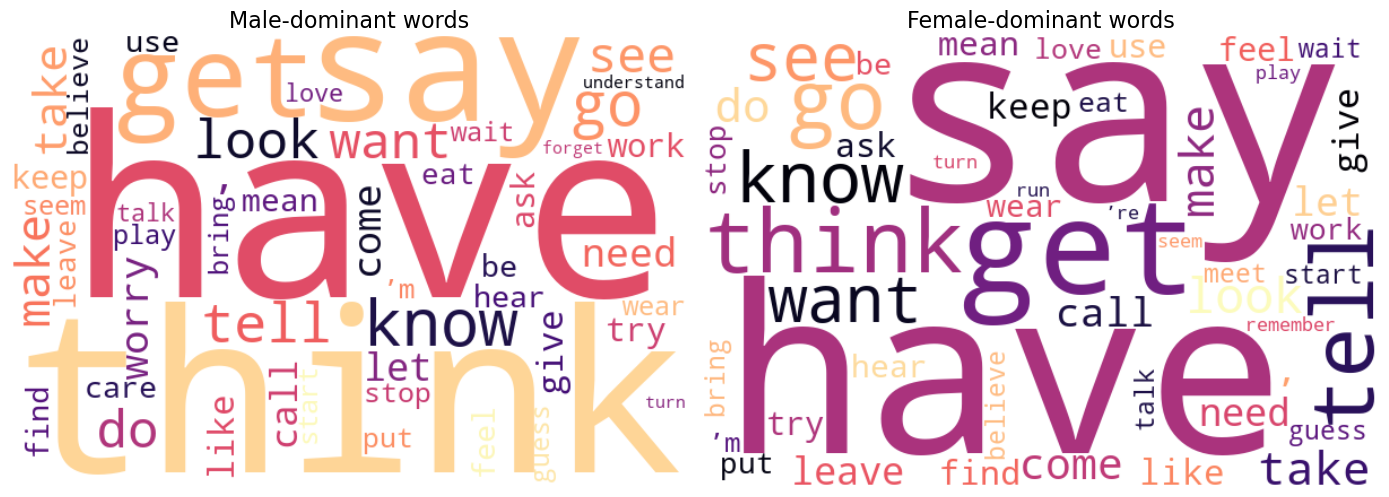

In [ ]:
# --- Generate the word clouds - VERB ---
male_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(verbs_male)

female_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(verbs_female)

ga.plot_wordclouds(male_cloud, female_cloud)

# size indicates frequency, color is just for esthetics

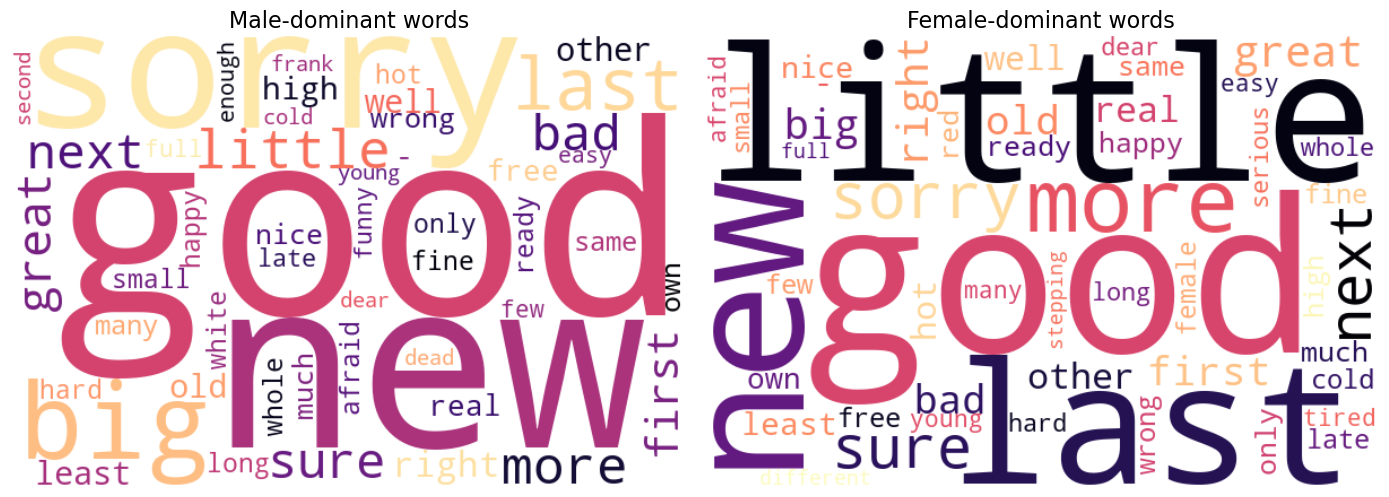

In [ ]:
# --- Generate the word clouds - ADJ ---
male_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(adjs_male)

female_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(adjs_female)

ga.plot_wordclouds(male_cloud, female_cloud)

### Topic modelling

https://www.geeksforgeeks.org/nlp/topic-modeling-using-latent-dirichlet-allocation-lda/

Combining topic modeling with sentiment analysis can provide insights into the sentiment associated with specific topics. This is useful in opinion mining and social media analysis.

For the man, there is a lot of captions, so i'll do it in four times. (100k max)

In [ ]:
## Creating two dataframes with all the men and women labelled captions

# caption_male_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'male'].copy(deep=True)
# caption_female_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'female'].copy(deep=True)

# for idx, contest in enumerate(data_caption[1:]):
#     print(f"Contest: {idx}")
#     male_caps = contest.loc[contest['gender_mention'] == 'male'].copy(deep=True)
#     frames = [caption_male_df, male_caps]
#     caption_male_df = pd.concat(frames)

#     female_caps = contest.loc[contest['gender_mention'] == 'female'].copy(deep=True)
#     frames_ = [caption_female_df, female_caps]
#     caption_female_df = pd.concat(frames_)

# # Save DataFrame to CSV
# caption_female_df.to_csv('all_caption_female.csv', index=False)
# caption_male_df.to_csv('all_caption_male.csv', index=False)

Contest: 0
Contest: 1
Contest: 2
Contest: 3
Contest: 4
Contest: 5
Contest: 6
Contest: 7
Contest: 8
Contest: 9
Contest: 10
Contest: 11
Contest: 12
Contest: 13
Contest: 14
Contest: 15
Contest: 16
Contest: 17
Contest: 18
Contest: 19
Contest: 20
Contest: 21
Contest: 22
Contest: 23
Contest: 24
Contest: 25
Contest: 26
Contest: 27
Contest: 28
Contest: 29
Contest: 30
Contest: 31
Contest: 32
Contest: 33
Contest: 34
Contest: 35
Contest: 36
Contest: 37
Contest: 38
Contest: 39
Contest: 40
Contest: 41
Contest: 42
Contest: 43
Contest: 44
Contest: 45
Contest: 46
Contest: 47
Contest: 48
Contest: 49
Contest: 50
Contest: 51
Contest: 52
Contest: 53
Contest: 54
Contest: 55
Contest: 56
Contest: 57
Contest: 58
Contest: 59
Contest: 60
Contest: 61
Contest: 62
Contest: 63
Contest: 64
Contest: 65
Contest: 66
Contest: 67
Contest: 68
Contest: 69
Contest: 70
Contest: 71
Contest: 72
Contest: 73
Contest: 74
Contest: 75
Contest: 76
Contest: 77
Contest: 78
Contest: 79
Contest: 80
Contest: 81
Contest: 82
Contest: 83
Co

In [ ]:
# ## TOPIC MODELLING: FINDING TOPICS WITH BERT AND LABELING EACH CAPTIONS WITH A TOPIC, THEN SAVING RESULTS

# # -------------------------------------
# # 1. Load captions
# # -------------------------------------
# data_m = pd.read_csv('all_caption_male.csv')
# captions = data_m['caption'].tolist()
# captions_1 = captions[:76619]
# captions_2 = captions[76619:153238]
# captions_3 = captions[153238:229857]
# captions_4 = captions[229857:]

In [ ]:
# # -------------------------------------
# # 1.5 Create list of lists of caption so that BERT can handle them
# # -------------------------------------

# captions_list = [captions_1, captions_2, captions_3, captions_4]

# # -------------------------------------
# # 2 Loop to iterate over all of the captions
# # -------------------------------------
# i = 0
# for captions_ in captions_list:
#     i+=1
#     # Better than default: tuned for short sentences
#     embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

#     # Compute caption embeddings
#     embeddings = embedding_model.encode(captions_, show_progress_bar=True)

#     # -------------------------------------
#     # 3. Create BERTopic model
#     # -------------------------------------
#     topic_model = BERTopic(
#         embedding_model=embedding_model,
#         min_topic_size=75,          # 25 for female, 75 for male (male has 5 times the captions)
#         n_gram_range=(1, 2),        # allow bigrams (important for humor)
#         verbose=True
#     )

#     # Fit model using embeddings
#     topics, probs = topic_model.fit_transform(captions_, embeddings)

#     # -------------------------------------
#     # 4. Inspect topics
#     # -------------------------------------
#     # topic_model.get_topic_info().head()

#     # -------------------------------------
#     # 5. Save results 
#     # -------------------------------------
#     df_topics = pd.DataFrame({
#         "caption": captions_,
#         "topic": topics,
#     })

#     df_topic_info_male = topic_model.get_topic_info()

#     df_topics.to_csv(f"caption_{i}_labeled_topics_male.csv", index=False)
#     df_topic_info_male.to_csv(f"info_topics_male_{i}.csv", index=False)

Batches:   0%|          | 0/2395 [00:00<?, ?it/s]

2025-12-09 02:13:12,730 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-09 02:14:25,742 - BERTopic - Dimensionality - Completed ✓
2025-12-09 02:14:25,749 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 02:14:56,471 - BERTopic - Cluster - Completed ✓
2025-12-09 02:14:56,519 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 02:15:01,013 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/2395 [00:00<?, ?it/s]

2025-12-09 02:27:59,635 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-09 02:28:43,657 - BERTopic - Dimensionality - Completed ✓
2025-12-09 02:28:43,662 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 02:28:57,076 - BERTopic - Cluster - Completed ✓
2025-12-09 02:28:57,107 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 02:29:01,285 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/2395 [00:00<?, ?it/s]

2025-12-09 02:44:05,363 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-09 02:44:48,085 - BERTopic - Dimensionality - Completed ✓
2025-12-09 02:44:48,090 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 02:45:03,472 - BERTopic - Cluster - Completed ✓
2025-12-09 02:45:03,508 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 02:45:08,067 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/2174 [00:00<?, ?it/s]

2025-12-09 02:57:01,812 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-09 02:57:34,343 - BERTopic - Dimensionality - Completed ✓
2025-12-09 02:57:34,348 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 02:57:45,873 - BERTopic - Cluster - Completed ✓
2025-12-09 02:57:45,897 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 02:57:50,074 - BERTopic - Representation - Completed ✓


#### Visualization

In [112]:
topics_female_info = pd.read_csv(r"src/info_topics_female.csv")
topics_female_caption = pd.read_csv(r"src/caption_labeled_topics_female.csv")

In [80]:
topics_male_info_1 = pd.read_csv(r"src/info_topics_male_1.csv")
topics_male_info_2 = pd.read_csv(r"src/info_topics_male_2.csv")
topics_male_info_3 = pd.read_csv(r"src/info_topics_male_3.csv")
topics_male_info_4 = pd.read_csv(r"src/info_topics_male_4.csv")

In [131]:
topics_male_caption_1 = pd.read_csv(r"src/caption_1_labeled_topics_male.csv")
topics_male_caption_2 = pd.read_csv(r"src/caption_2_labeled_topics_male.csv")
topics_male_caption_3 = pd.read_csv(r"src/caption_3_labeled_topics_male.csv")
topics_male_caption_4 = pd.read_csv(r"src/caption_4_labeled_topics_male.csv")

When I used BERTopic, it found 362 topics with at least 25 words in each of them. Some of them are a bit redundant, so I went through the top 100 topic ranked by number of captions and aggregated the theme that were close. 

This results in the following dictionnary. 

In [120]:
agg_topic_female = {
    # 1. Female archetypes ok
    "1_queen_the queen_my queen_majesty": "Female archetypes",
    "4_trophy_trophy wife_your trophy_wife": "Female archetypes",
    "5_hillary_for hillary_voted_voted for": "Female archetypes",
    "21_witch_wicked witch_wicked_the witch": "Female archetypes",
    "47_bee_queen bee_queen_bees": "Female archetypes",
    "51_bride_the bride_you may_may now": "Female archetypes",
    "83_kardashian_kim_the kardashian_kim kardashian": "Female archetypes",
    "88_of herself_herself_her everywhere_herself she": "Female archetypes",
    "40_then she_then_and then_told her": "Female archetypes",
    "52_hey lady_cake_hey_lady": "Female archetypes",
    "60_ma am_ma_am_buy it": "Female archetypes",
    "3_women_woman_female_girls": "Female archetypes",

    # 2. Family roles ok
    "-1_she_her_mother_mom": "Family roles",
    "0_wife_my wife_your wife_ex": "Family roles",
    "11_sister_your sister_sisters_my sister": "Family roles",
    "14_grandma_grandmother_great great_great": "Family roles",
    "87_granddaughter_my granddaughter_my daughter_daughter": "Family roles",
    "70_aunt_jemima_aunt jemima_your aunt": "Family roles",
    "94_mother nature_nature_nature is_mother": "Family roles",
    "79_bagged_bagged that_that one_granddaughter": "Family roles",

    # 3. Female names ok
    "6_karen_karen you_karen it_you karen": "Female names",
    "17_susan_susan susan_susan you_susan we": "Female names",
    "24_martha_martha you_martha martha_you martha": "Female names",
    "46_helen_helen you_you helen_helen but": "Female names",
    "54_linda_linda you_me linda_linda this": "Female names",
    "55_carol_carol carol_christmas carol_carol they": "Female names",
    "68_doris_irene_doris you_leaving": "Female names",
    "71_her name_name_eve_name is": "Female names",
    "77_margaret_you margaret_margaret margaret_atwood": "Female names",
    "91_janet_janet it_and janet_you janet": "Female names",
    "92_betty_crocker_betty crocker_barney": "Female names",
    "23_alice_the moon_moon_moon alice": "Female names",
    "64_mrs_butterworth_mrs butterworth_sisyphus": "Female names",
    "61_dorothy_kansas_dorothy and_toto": "Female names",

    # 4. Food ok
    "18_cake_the cake_cake and_cake she": "Food",
    "9_feed_feed her_eat_to feed": "Food",
    "34_recipe_mother recipe_recipes_mom recipe": "Food",
    "89_food_mom_midnight_snacking": "Food",
    "20_mustard_ketchup_low_low on": "Food",
    "15_fish_like fish_drink like_drink": "Food",
    "28_lemons_lemonade_you lemons_gives you": "Food",
    "66_wine_blood_red_red wine": "Food",
    "37_grande_latte_venti_rio": "Food",
    "69_vegan_vegetarian_she vegan_organic": "Food",

    # 5. Clothing, fashion & appearance ok
    "8_dress_fashion_wearing_wear": "Fashion & appearance",
    "35_shoes_shoe_her shoes_in shoe": "Fashion & appearance",
    "78_hair_her hair_hair she_your hair": "Fashion & appearance",
    "81_wear_wear this_dressed_dress": "Fashion & appearance",
    "85_taller_smaller_look fat_height": "Fashion & appearance",
    "90_lips_her lips_lip_red lips": "Fashion & appearance",
    "59_collar_the collar_hot under_under the": "Fashion & appearance",
    "98_ruff_ruff on_ruff she_the ruff": "Fashion & appearance",
    "33_neck_her neck_neck she_neck out": "Fashion & appearance",

    # 6. Animals ok
    "10_dog_her dog_pet_the dog": "Animals",
    "22_cat_cat lady_the cat_cats": "Animals",
    "65_mosquitoes_mosquito_mosquitos_spray": "Animals",
    "58_mouse_mice_rat_lab": "Animals",
    "12_peep_sheep_bo_bo peep": "Animals",

    # 7. Motherhood & parenting ok
    "16_about your_your mother_about_tell me": "Motherhood",
    "63_visit_to visit_your mother_visiting": "Motherhood",
    "73_call_mother called_phone_call your": "Motherhood",

    # 8. Health, therapy & aging ok
    "53_effects_side effects_acupuncture_viagra": "Health",
    "84_therapist_therapy_my therapist_your therapist": "Health",
    "72_diet_new diet_serious about_mom is": "Health",

    # 9. Work / finance / real estate ok
    "48_college_mom_job_student": "Work & education",
    "50_note_she left_left note_left": "Work & education",
    "42_emails_her emails_email_server": "Work & education",

    # 10. Activities 
    "82_book_books_read_author": "Activities",
    "43_band_drummer_drum_beat": "Activities",

    # 11. Weather / seasons / nature ok
    "2_summer_the summer_this summer_fall": "Nature",
    "32_autumn_leaves_autumn leaves_the autumn": "Nature",
    "29_rose_rose garden_the rose_garden": "Nature",
    "93_water_the water_for water_to water": "Nature",
    "57_hudson_the hudson_hudson river_river": "Nature",
    "67_parade_rain_her parade_rain on": "Nature",

    # 12. Mariage & Divorce ok
    "7_divorce_papers_divorce papers_the divorce": "Mariage & Divorce",
    "27_in half_half_trick_her in": "Mariage & Divorce",
    "4_trophy_trophy wife_your trophy_wife": "Mariage & Divorce",

    # 13. Climate
    "36_earth_mother earth_climate_climate change": "climate",

    # 14. Fantasy / mythology ok
    "25_knight_armor_shining_in shining": "Fantasy & mythology",
    "62_sword_the sword_her sword_scythe": "Fantasy & mythology",
    "21_witch_wicked witch_wicked_the witch": "Fantasy & mythology",
    "13_princess_the princess_castle_princess is": "Fantasy & mythology",
    "38_dragon_dragons_the dragon_of dragons": "Fantasy & mytholog",

    # 15. COVID / pandemic ok
    "41_quarantine_vaccine_covid_in quarantine": "COVID & pandemic",
    "97_mask_masks_wear mask_wear": "COVID & pandemic",


    # 18. History ok
    "44_neanderthal_dinosaurs_rex_dinosaur": "History",
    "19_stone_in stone_the stone_stone throw": "History",
    "31_stone age_age_the stone_stone": "History",

    # 19. Religion / morality ok
    "74_grace_your grace_amazing grace_amazing": "Religion",
    "76_faith_faith in_of faith_leap of": "Religion",

    # Money
    "49_price_costco_the price_breaks": "Money",

    # House
    "56_apartment_rent_realtor_the realtor": "House",
    "96_moving_move_with us_moving back": "House",
    "45_elevator_the elevator_stairs_hell": "House",

    # 20. Misc ok
    "26_bull_china_shop_china shop": "Miscellaneous",
    "86_hiding_she hiding_the left_hiding something": "Miscellaneous",
    "39_madame_monsieur_et_and monsieur": "Miscellaneous",
    "30_size_matter_size doesn_doesn matter": "Miscellaneous",
    "75_stepping stone_stepping_your stepping_stone": "Miscellaneous",
    "27_in half_half_trick_her in": "Miscellaneous",
    "80_couch_this couch_sofa_the couch": "Miscellaneous",
    "95_color_colors_true colors_true": "Miscellaneous", 
}


In [121]:
agg_topic_male_1 = {
    # Male archetypes
    "-1_don_he_to_the": "Male Archetypes", 
    "0_him_he_tell him_think he": "Male Archetypes", 
    "17_sir_arrived_brain_amazon": "Male Archetypes", 
    "35_last man_on earth_earth_man on": "Male Archetypes", 
    "39_men_man_male_man again": "Male Archetypes", 

    # Male names

    # Animals
    "16_whale_whale of_white whale_white": "Animals", 
    "10_cat_the cat_cats_leg": "Animals", 
    "20_bird_birds_the bird_pigeons": "Animals", 
    "33_mouse_mice_rat_the mice": "Animals", 
    "40_fish_tuna_fish out_of water": "Animals", 

    # Climate

    # Clothing
    "27_shoes_boots_those_his shoes": "Fashion & appearance",

    # COVID / Pandemic

    # Death
    "6_penalty_death_death penalty_the death": "Death",

    # Family roles

    # Fantasy / mythology
    "14_damocles_sword_the sword_pen": "Fantasy & mythology",
    "30_peter_peter pan_pan_hoop": "Fantasy & mythology",

    # Fatherhood
    "5_dad_father_your father_your dad": "Fatherhood", 

    # Money
    "21_stocks_stock_in stocks_stocks he": "Money", 

    # Food
    "12_dinner_for dinner_sir will_dinner sir": "Food", 
    "25_pizza_paparazzi_pizzarazzi_pepperoni": "Food", 
    "47_donut_doughnut_donuts_bagel": "Food", 

    # Health
    "11_doctor_results_fraternity_mr": "Health", 
    "13_insurance_health_obamacare_care": "Health",

    # History
    "8_cave_man cave_man_his man": "History",

    # House
    "48_rent_house_housing_housebroken": "House", 
    "45_bathroom_the bathroom_toilet_the toilet": "House", 

    # Nature
    "23_plant_he plant_potted_potted plant": "Nature", 

    # Public Figures
    "22_hitchcock_mr hitchcock_alfred_alfred hitchcock": "Public Figures",

    # Trump
    "7_donald_trump_him donald_donald trump": "Trump",
    "9_voted_voted for_vote_for trump": "Trump",
    "19_wall_the wall_build_build wall": "Trump",
    "32_wave_trump wave_waves_trump": "Trump",

    # Pop culture
    "42_frank_stein_frank you_be frank": "Pop Culture",

    # Religion and Morality
    "1_pie_apple_adam_eve": "Religion",
    "43_sweater_moses_god_thou": "Religion",
    "46_george_george you_st george_george is": "Religion",

    # Royal
    "2_king_the king_majesty_royal": "Royalty", 

    # Social
    "37_tweet_twitter_tweeting_tweets": "Social",

    # Work
    "26_boss_the boss_fired_re fired": "Work",
    "38_lawyers_lawyer_legal_case": "Work",
    "41_chairman_the chairman_chairman of_board": "Work",

    # Misc
    "3_don worry_worry_don_don know": "Miscellaneous",
    "4_reinventing_himself_invented_reinvent": "Miscellaneous",
    "15_yoga_mat_rug_carpet": "Miscellaneous",
    "18_size_bigger_matter_doesn matter": "Miscellaneous",
    "24_rock_rock and_roll_rock faster": "Miscellaneous",
    "28_sandbox_sand_the sandbox_desert": "Miscellaneous",
    "29_gravity_the gravity_gravity of_situation": "Miscellaneous",
    "31_wake_sleep_bed_nap": "Miscellaneous",
    "34_speed_you were_were going_the speed": "Miscellaneous",
    "36_printer_carl_3d_3d printer": "Miscellaneous",
    "44_shovel_snow_the shovel_son": "Miscellaneous"

}

In [122]:
agg_topic_male_2 = {
    # Male archetypes
    "-1_don_the_he_you": "Male Archetypes", 
    "0_him_he_follow_us": "Male Archetypes", 

    # Male names

    # Arts / Music
    "1_art_artist_work_his": "Arts & Music",
    "5_piano_piano man_the piano_play": "Arts & Music",

    # Animals
    "2_dog_park_the dog_sir": "Animals", 
    "21_fish_like fish_drink_drink like": "Animals", 
    "39_row_duck_ducks_quack": "Animals", 

    # Climate
    "8_global_global warming_warming_climate": "Climate", 

    # Clothing and Appearances
    "17_pants_wearing_pants he_clothes": "Fashion & appearance",
    "19_hair_bald_your hair_beard": "Fashion & appearance",
    "24_hands_big_big guy_the big": "Fashion & appearance",
    "37_high_he high_high don_looks high": "Fashion & appearance",
    "42_feet_his feet_foot_shoes": "Fashion & appearance",

    # COVID / Pandemic

    # Death
    "18_death_he died_died_killed": "Death",

    # Family roles

    # Fantasy / mythology
    "20_sword_the sword_desk_he who": "Fantasy & mythology",

    # Fatherhood
    "3_father_organ_steam_pipes": "Fatherhood", 
    "27_dad_father_your father_your dad": "Fatherhood", 

    # Money
    "32_tax_taxes_tax returns_returns": "Money", 

    # Food
    "14_coffee_toast_wish_toaster": "Food", 
    "26_drink_beer_don drink_drink like": "Food", 
    "29_hot_hot dogs_dogs_hot dog": "Food", 
    "31_gingerbread_ginger_gingerbread man_the gingerbread": "Food", 
    "34_eat_eat him_to eat_feed him": "Food", 
    "43_menu_the menu_menu sir_sir": "Food", 

    # Health

    # History
    "9_arthur_king arthur_king_arthur is": "History",
    "38_cave_man cave_the cave_cave man": "History",

    # House

    # Nature
    "16_seasonal_seasonal help_he seasonal_just seasonal": "Nature",
    "33_leaves_rake_leaf_tree": "Nature",

    # Public Figures
    "22_luther_martin_martin luther_messenger": "Public Figures",

    # Politics
    "10_trump_donald_donald trump_president": "Trump",
    "41_putin_mueller_notes_russian": "Trump",

    # Pop culture

    # Religion and Morality
    "12_god_of god_heaven_an act": "Religion",

    # Royal

    # Social
    "25_cable_channel_tv_netflix": "Social",

    # Sport
    "6_ball_bat_the ball_hit"
    "7_kite_kites_park_your kite"

    # Transport
    "15_train_model_trains_train set"
    "28_flight_fly_plane_flying"
    "46_uber_ride_driver_an uber"

    # Work
    "13_cop_good cop_bad cop_the good": "Work",

    # Misc
    "11_rock_rock and_between rock_and hard": "Miscellaneous",
    "4_don_look down_step_don worry": "Miscellaneous",
    "23_abominable_abominable he_him abominable_not abominable": "Miscellaneous",
    "30_swing_hits_hits it_world": "Miscellaneous",
    "35_galaxy_guide to_the galaxy_guide": "Miscellaneous",
    "36_clown_clowning_clowning around_bad clown": "Miscellaneous",
    "40_bite_teething_chew_don bite": "Miscellaneous",
    "44_table_round_round table_tables": "Miscellaneous",
    "45_won last_spring_last_be gone": "Miscellaneous",
    "47_frosty_customers_frosty he_the customers": "Miscellaneous",
    "48_selfie_camera_selfie with_mirror": "Miscellaneous",

}

In [123]:
agg_topic_male_3 = {
    # Male archetypes

    # Male names
    "43_harold_harold you_harold harold_harold it": "Male names", 

    # Arts / Music
    "41_singing_song_guitar_he singing": "Arts & Music",

    # Animals
    "7_the king_horses_king horses_all the": "Animals", 
    "31_bird_birds_the birds_free bird": "Animals", 
    "34_bear_honey_honey bear_the bear": "Animals", 
    "37_salmon_the salmon_fresh_fish": "Animals", 
    "44_shark_sharks_the sharks_the shark": "Animals", 

    # Climate
    "39_climate_climate change_warming_global warming": "Climate",

    # Clothing and Appearances
    "3_tie_dress_jacket_pants": "Fashion & appearance",
    "22_hair_my hair_trim_haircut": "Fashion & appearance",
    "40_hat_scarf_hats_knit": "Fashion & appearance",

    # COVID / Pandemic
    "35_virus_covid_coronavirus_covid 19": "COVID & pandemic",

    # Death

    # Family roles
    "10_brother_big brother_big_your big": "Family roles",

    # Fantasy / mythology

    # Fatherhood
    "12_father_dad_your father_my father": "Fatherhood", 

    # Money
    "33_rent_neighbor_downstairs_apartment": "Money",

    # Food
    "6_feed_feed him_him_eat": "Food", 
    "8_egg_nest egg_nest_an egg": "Food", 
    "9_drink_wine_red_glass": "Food", 
    "18_toast_sorry sir_sorry_toast sorry": "Food", 
    "20_rock_candy_rock candy_big rock": "Food", 
    "25_cheese_the cheese_cheese he_cheese don": "Food", 
    "28_gluten_gluten free_free_is gluten": "Food", 
    "29_burger_burger king_king_burgers": "Food", 

    # Health
    "17_effects_side effects_side_prescription": "Health",
    "30_diet_paleo_weight_carbs": "Health",
    "47_couch_lips_lip_therapy": "Health",

    # History

    # House

    # Mariage
    "21_cruise_viking_honeymoon_viking cruise"

    # Nature

    # Public Figures

    # Politics
    "32_wall_the wall_trump wall_trump": "Trump",

    # Pop culture
    "27_edward_scissorhands_edward scissorhands_movie": "Pop Culture",

    # Religion and Morality
    "26_george_flowers_st george_george is": "Religion",

    # Royal
    "5_king_the king_king of_be king": "Royalty",

    # Social
    "42_netflix_tv_password_account": "Social",

    # Sport
    "36_baseball_home run_pitch_home"
    "48_jay_blues jay_blues_blue jay"

    # Transport
    "23_clown_clowns_car_clown car"
    "24_train_the train_subway_trains"

    # Work
    "4_door_lane_officer_opened": "Work",
    "14_coffee_barista_jack_latte": "Work",
    "15_soup_my soup_waiter_waiter there": "Work",
    "16_work_job_home_from home": "Work",

    # Misc
    "11_disappear_court_contempt_magic": "Miscellaneous",
    "13_diversity_our_our new_new": "Miscellaneous",
    "19_weight_the weight_weight of_the world": "Miscellaneous",
    "38_parade_macy_balloon_thanksgiving": "Miscellaneous",
    "45_stand up_stand_up_first stand": "Miscellaneous",
    "46_hatch_hatching_to hatch_hatches": "Miscellaneous"

}

In [124]:
agg_topic_male_4 = {
    # Male archetypes
    "-1_he_don_you_the": "Male Archetypes", 
    "21_good boy_boy_good_who good": "Male Archetypes", 
    "25_man_men_man who_like man": "Male Archetypes", 

    # Male names

    # Arts / Music
    "7_art_monet_sir_burgers": "Arts & Music",
    "46_roll_rock_and roll_rock and": "Arts & Music",

    # Animals
    "19_fish_the fish_fishes_seafood": "Animals", 
    "28_rabbit_the rabbit_hat_rabbit out": "Animals", 
    "31_lion_the lion_daniel_circus": "Animals", 
    "43_dog_the dog_dogs_son": "Animals", 

    # Climate
    "27_climate_weather_climate change_the weather": "Climate", 

    # Clothing and Appearances
    "2_sheep_wool_clothing_sheep clothing": "Fashion & appearance",
    "5_suit_wear_dress_clothes": "Fashion & appearance",
    "11_mask_masks_wear_to wear": "Fashion & appearance",
    "40_shoes_shoe_shoes don_match": "Fashion & appearance",

    # COVID / Pandemic
    "37_covid_covid 19_19_virus": "COVID & pandemic",

    # Death

    # Family roles
    "18_brother_your brother_your_little brother": "Family roles",

    # Fantasy / mythology
    "36_moon_the moon_man in_the man": "Fantasy & mythology",

    # Fatherhood
    "6_father_dad_your father_your dad": "Fatherhood", 

    # Money
    "48_insurance_his insurance_the insurance_our insurance": "Money",

    # Food And Drinks
    "3_lemonade_lemons_make lemonade_you lemons": "Food", 
    "15_rat_lab_mouse_mice": "Food", 
    "22_mustard_ketchup_relish_jackson": "Food", 
    "24_wine_drink_for drink_drinking": "Food", 
    "32_dinner_eat_lunch_ate": "Food", 
    "41_apple_an apple_dad_the apple": "Food", 


    # Health

    # History
    "17_cave_man cave_man_your man": "History",

    # House
    "12_piano_the house_house_house down": "House", 
    "16_water_boss_clean_shower": "House", 
    "47_houses_house_flipping_flip": "House", 

    # Mariage
    "34_cake_groom_down cake_the cake": "Mariage",

    # Nature
    "13_rock_the rock_rocks_rock and": "Nature",
    "42_leaves_leaf_the leaves_rake": "Nature",

    # Public Figures
    "44_george_karma_boy george_martin": "Public Figures",

    # Politics
    "4_trump_donald_election_vote": "Trump",

    # Pop culture
    "0_jack_cloud_bean_beans": "Pop Culture",
    "8_pet_boys_beach_beach boys": "Pop Culture",

    # Religion and Morality

    # Royal

    # Social

    # Sport

    # Transport

    # Work
    "1_your honor_honor_witness_bear": "Work",
    "23_salesman_sales_our best_best": "Work",
    "45_hired_hire_hired him_job": "Work",

    # Misc
    "9_book_books_author_read": "Miscellaneous",
    "10_city_the city_he ll_pace": "Miscellaneous",
    "14_square_round_hole_peg": "Miscellaneous",
    "20_don worry_worry_don_worry we": "Miscellaneous",
    "26_china_china shop_shop_china he": "Miscellaneous",
    "29_feel_don feel_feel seen_don see": "Miscellaneous",
    "30_upside_upside down_down_world": "Miscellaneous",
    "33_bite_don bite_males_bite don": "Miscellaneous",
    "35_friendly_nice_he nice_he friendly": "Miscellaneous",
    "38_ignore him_ignore_attention_just ignore": "Miscellaneous",
    "39_bubble_burst_your bubble_burst your": "Miscellaneous"
}

In [125]:
# Convert keys like "3_women_woman..." into int IDs
agg_topic_female_int = {
    int(key.split("_")[0]): value
    for key, value in agg_topic_female.items()
}

In [127]:
df_topics = pd.DataFrame({
    "caption": topics_female_caption['caption'].values,
    "topic": topics_female_caption['topic'].values
})

df_topics["aggregated_theme"] = df_topics["topic"].map(agg_topic_female_int)

df_topics = df_topics.sort_values('topic')

df_topics.head()

,caption,topic,aggregated_theme
53269,"i’m sorry ma’am. we do have diesel and petrol,...",-1,Family roles
20095,kathy wants to know if you like her. check the...,-1,Family roles
49,my wife wants me to understand how it feels to...,-1,Family roles
48,mom was right. they really did walk all over me.,-1,Family roles
45,i'm still have faith in trickle-down economics.,-1,Family roles


In [128]:
df_topics = df_topics.dropna(subset=["aggregated_theme"])
df_topics.isna().sum()

caption             0
topic               0
aggregated_theme    0
dtype: int64

In [129]:
theme_counts = df_topics["aggregated_theme"].value_counts().sort_values(ascending=False)
print(theme_counts)

aggregated_theme
Family roles            21720
Female archetypes        3508
Female names             2474
Food                     2035
Nature                   1718
Fashion & appearance     1396
Mariage & Divorce        1170
Miscellaneous            1147
Animals                  1110
Fantasy & mythology       880
History                   584
Motherhood                506
Work & education          452
House                     387
Health                    364
Activities                264
COVID & pandemic          259
Religion                  227
climate                   167
Fantasy & mytholog        166
Money                     144
Name: count, dtype: int64


In [130]:
circle_data = []

# remove female archetypes
for theme in theme_counts.index:
    if theme == "Female archetypes":
        continue
    if theme == "Miscellaneous":
        continue
    theme_size = theme_counts[theme]

    circle_data.append(dict(
        id=theme,
        parent="",
        value=theme_size
    ))

df_circles = pd.DataFrame(circle_data)

fig = px.treemap(
    df_circles,
    names="id",
    parents="parent",
    values="value",
    title="Themes in female labeled captions"
)

fig.update_traces(root_color="lightgrey")

fig.update_traces(
    hovertemplate="<b>%{label}</b><br>Count: %{value}<extra></extra>"
)

fig.show()


In [ ]:
# Convert keys like "3_women_woman..." into int IDs
agg_topic_male_int_1 = {
    int(key.split("_")[0]): value
    for key, value in agg_topic_male_1.items()
}
agg_topic_male_int_2 = {
    int(key.split("_")[0]): value
    for key, value in agg_topic_male_1.items()
}
agg_topic_male_int_3 = {
    int(key.split("_")[0]): value
    for key, value in agg_topic_male_1.items()
}
agg_topic_male_int_4 = {
    int(key.split("_")[0]): value
    for key, value in agg_topic_male_1.items()
}

In [ ]:
df_topics = pd.DataFrame({
    "caption": topics_female_caption['caption'].values,
    "topic": topics_female_caption['topic'].values
})

df_topics["aggregated_theme"] = df_topics["topic"].map(agg_topic_female_int)

df_topics = df_topics.sort_values('topic')

df_topics.head()

### Sentiment Analysis

#### Over all the contests

In [36]:
caption_female_df = pd.read_csv(r"src/all_caption_female.csv")
caption_male_df = pd.read_csv(r"src/all_caption_male.csv")

In [37]:
male_caps   = caption_male_df['caption'].tolist()
female_caps = caption_female_df['caption'].tolist()

In [ ]:
nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

positive_sent_ = []
negative_sent_ = []
total_sent_ = []
i = 0
# #iterate through the sentences, get polarity scores, choose a value
for doc in nlp.pipe(female_caps):
    if i % 10000 == 0: 
        print(f"Sentiment Analysis of the {i}th caption")
    for sent in doc.sents:
        positive_sent_.append(analyzer.polarity_scores(sent.text)['pos'])
        negative_sent_.append(analyzer.polarity_scores(sent.text)['neg'])
        total_sent_.append(analyzer.polarity_scores(sent.text)['compound']) 
    i += 1

Sentiment Analysis of the 0th caption
Sentiment Analysis of the 10000th caption
Sentiment Analysis of the 20000th caption
Sentiment Analysis of the 30000th caption
Sentiment Analysis of the 40000th caption
Sentiment Analysis of the 50000th caption


Text(0, 0.5, 'Number of sentences')

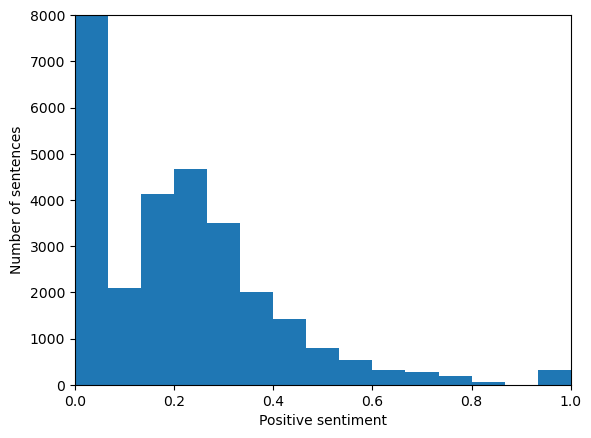

In [51]:
plt.hist(positive_sent_,bins=15)
plt.xlim([0,1])
plt.ylim([0,8000])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of sentences')

Text(0, 0.5, 'Number of sentences')

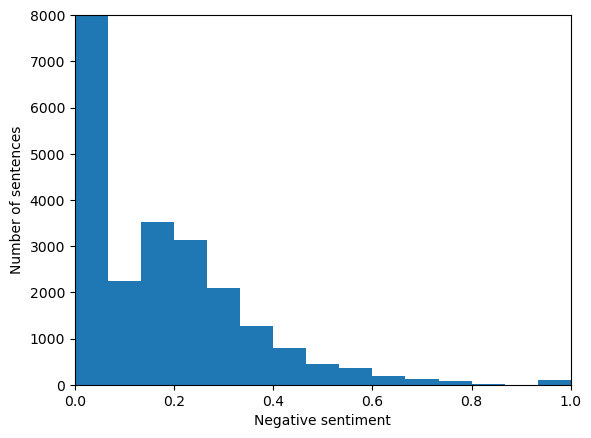

In [52]:
plt.hist(negative_sent_,bins=15)
plt.xlim([0,1])
plt.ylim([0,8000])
plt.xlabel('Negative sentiment')
plt.ylabel('Number of sentences')

In [58]:
# sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in doc.sents]
print(f'Number of positive sentences: {sum(np.array(total_sent_)>=0.05)/len(total_sent_)}')
print(f'Number of negative sentences:{sum(np.array(total_sent_)<=-0.05)/len(total_sent_)}')
print(f'Number of neutral sentences: {sum(np.abs(np.array(total_sent_))<0.05)/len(total_sent_)}')

Number of positive sentences: 0.27378097521982414
Number of negative sentences:0.17876069514758564
Number of neutral sentences: 0.5474583296325902


In [ ]:
positive_sent = []
negative_sent = []
total_sent = []
i = 0
# #iterate through the sentences, get polarity scores, choose a value
for doc in nlp.pipe(male_caps):
    if i % 10000 == 0: 
        print(f"Sentiment Analysis of the {i}th caption")
    for sent in doc.sents:
        positive_sent.append(analyzer.polarity_scores(sent.text)['pos'])
        negative_sent.append(analyzer.polarity_scores(sent.text)['neg'])
        total_sent.append(analyzer.polarity_scores(sent.text)['compound']) 
    i += 1

Sentiment Analysis of the 0th caption
Sentiment Analysis of the 10000th caption
Sentiment Analysis of the 20000th caption
Sentiment Analysis of the 30000th caption
Sentiment Analysis of the 40000th caption
Sentiment Analysis of the 50000th caption
Sentiment Analysis of the 60000th caption
Sentiment Analysis of the 70000th caption
Sentiment Analysis of the 80000th caption
Sentiment Analysis of the 90000th caption
Sentiment Analysis of the 100000th caption
Sentiment Analysis of the 110000th caption
Sentiment Analysis of the 120000th caption
Sentiment Analysis of the 130000th caption
Sentiment Analysis of the 140000th caption
Sentiment Analysis of the 150000th caption
Sentiment Analysis of the 160000th caption
Sentiment Analysis of the 170000th caption
Sentiment Analysis of the 180000th caption
Sentiment Analysis of the 190000th caption
Sentiment Analysis of the 200000th caption
Sentiment Analysis of the 210000th caption
Sentiment Analysis of the 220000th caption
Sentiment Analysis of the

Text(0, 0.5, 'Number of sentences')

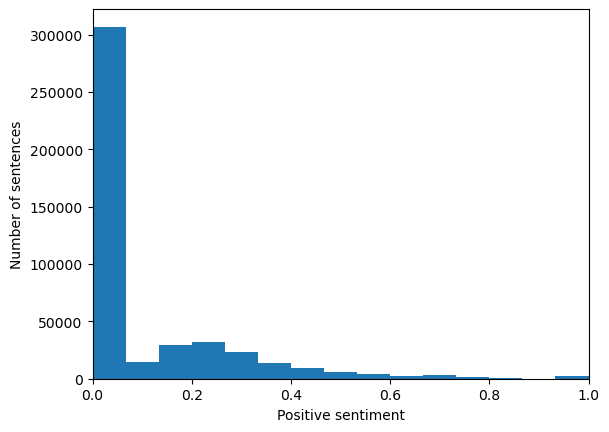

In [47]:
plt.hist(positive_sent,bins=15)
plt.xlim([0,1])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of sentences')

Text(0, 0.5, 'Number of sentences')

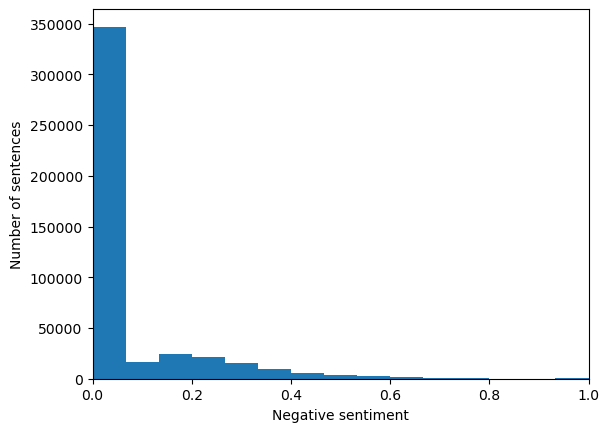

In [48]:
plt.hist(negative_sent,bins=15)
plt.xlim([0,1])
plt.xlabel('Negative sentiment')
plt.ylabel('Number of sentences')

Text(0, 0.5, 'Proportion of sentences')

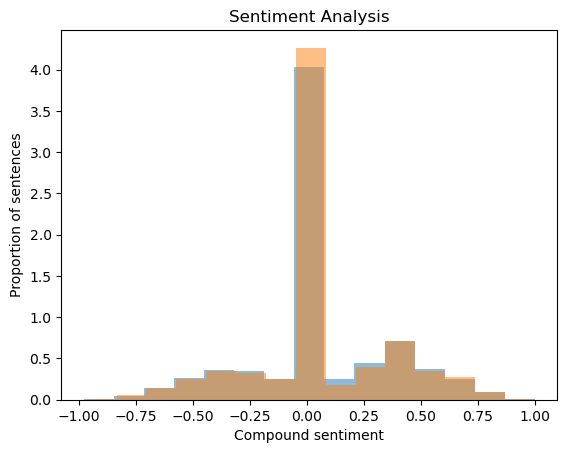

In [97]:
plt.hist(total_sent,bins = 15, density=True, label = 'male captions', alpha = 0.5)
plt.title("Sentiment Analysis")

plt.hist(total_sent_,bins = 15, density=True, label = 'female caption', alpha = 0.5)
plt.xlabel('Compound sentiment')
plt.ylabel('Proportion of sentences')

In [56]:
print('Ratio of positive sentences:',sum(np.array(total_sent)>=0.05)/len(total_sent))
print('Ratio of negative sentences:',sum(np.array(total_sent)<=-0.05)/len(total_sent))
print('Ration of neutral sentences:',sum(np.abs(np.array(total_sent))<0.05)/len(total_sent))

Ratio of positive sentences: 0.28482150214812124
Ratio of negative sentences: 0.18990104610943948
Ration of neutral sentences: 0.5252774517424392


Same distribution, not a clear difference.

#### Evolution over time - NOT SIGNIFICANT

Compute a mean + std of coumpound sentiment. Scatter plot with one color for male and the other for female, include dotted lines that shows positive and negative sentiment.

In [38]:
### --- MODELS ---
nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()
### --------------

mean_sent_female = []
std_sent_female = []
mean_sent_male = []
std_sent_male = []
# to store the sentiment score associated with each caption
all_sentiment_female = []
all_sentiment_male = []

### --- Sentiment score ---
for contest in data_caption:

    male_caps   = contest[contest['gender_mention'] == 'male']['caption'].tolist()
    female_caps = contest[contest['gender_mention'] == 'female']['caption'].tolist()

    sent_female = []
    sent_male = []
    
    # #iterate through the sentences, get polarity scores
    for doc in nlp.pipe(female_caps):
        for sent in doc.sents:
            sent_female.append(analyzer.polarity_scores(sent.text)['compound'])
        
    for doc in nlp.pipe(male_caps):
        for sent in doc.sents:
            sent_male.append(analyzer.polarity_scores(sent.text)['compound'])

    mean_sent_male.append(np.mean(sent_male))
    std_sent_male.append(np.std(sent_male))
    mean_sent_female.append(np.mean(sent_female))
    std_sent_female.append(np.std(sent_female))

    all_sentiment_female.append(sent_female)
    all_sentiment_male.append(sent_male)

### ------------------------

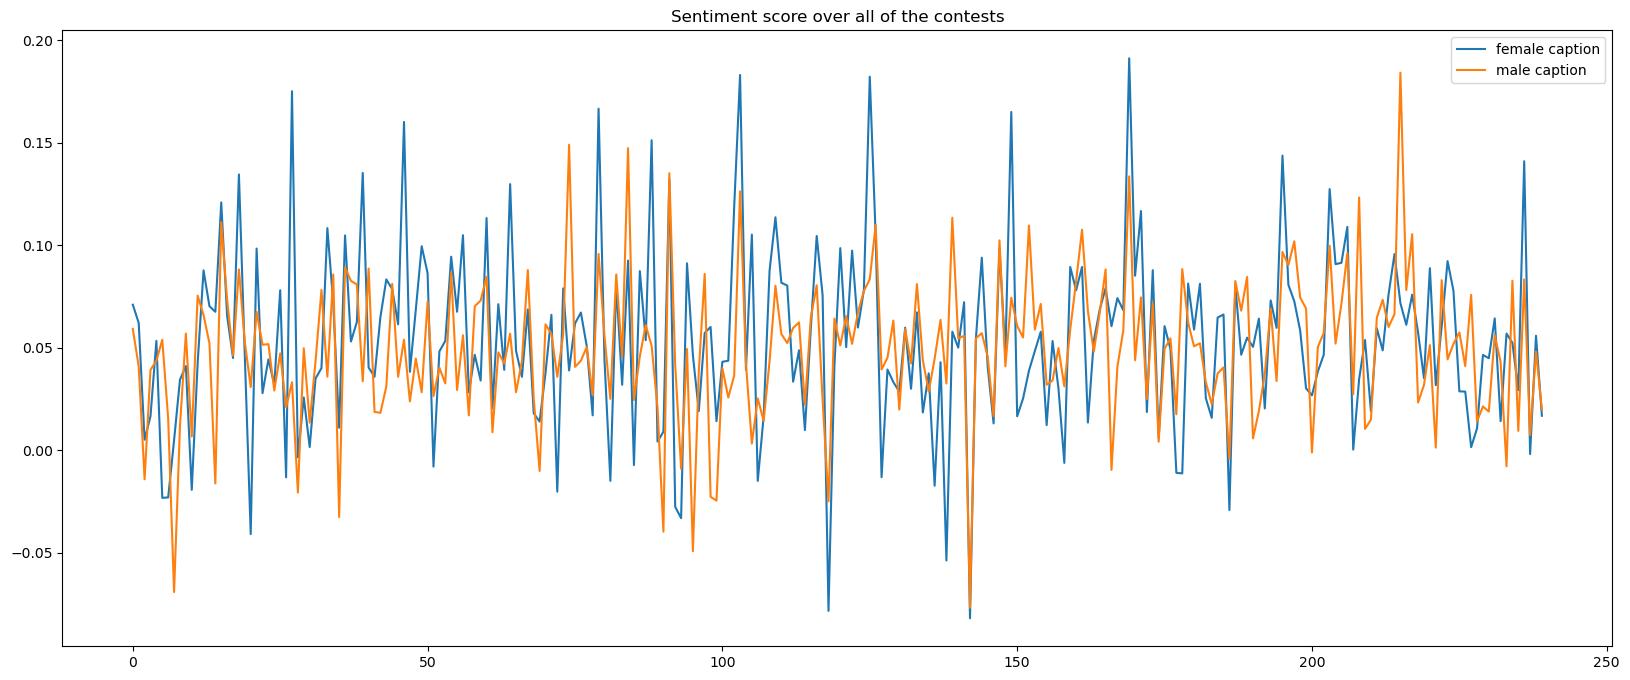

In [123]:
### --- PLOTS ---
plt.figure(figsize=(20,8))
plt.title("Sentiment score over all of the contests")
plt.plot(mean_sent_female, label = 'female caption')
plt.plot(mean_sent_male, label = 'male caption')
plt.legend()

#### Statistical testing

First visualize the distribution to pick an appropriate test.

In [41]:
len(all_sentiment_female)

240

In [42]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

list_all_sentiment_female = flatten(all_sentiment_female)
list_all_sentiment_male = flatten(all_sentiment_male)

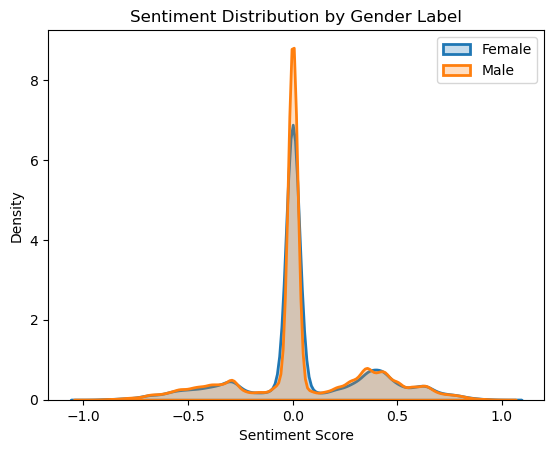

In [43]:
sns.kdeplot(list_all_sentiment_female, fill=True, label = 'Female', linewidth=2)
sns.kdeplot(list_all_sentiment_male, fill=True, label="Male", linewidth=2)

plt.title("Sentiment Distribution by Gender Label")
plt.xlabel("Sentiment Score")
plt.legend()
plt.show()

Null hypothesis H₀:

There is no significant difference in sentiment score between male and female captions.

Decision rule:

If p-value < 0.05 → reject H₀ → sentiment differs between male and female captions

If p-value ≥ 0.05 → fail to reject H₀ → no evidence of difference

In [44]:
u_stat, p_value = mannwhitneyu(list_all_sentiment_female, list_all_sentiment_male, alternative="two-sided")
print("Mann-Whitney U:", u_stat)
print("p-value:", p_value)

Mann-Whitney U: 12906225285.0
p-value: 0.44118922622203616


## Step 3: How does audience response relate to gendered content ? 

In [17]:
STORED_DATACAPTION_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions_1.pkl'
data_caption = ga.load_pickle(STORED_DATACAPTION_PKL_PATH)

In [19]:
# Creating two dataframes with all the men and women labelled captions

caption_male_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'male'].copy(deep=True)
caption_female_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'female'].copy(deep=True)

for idx, contest in enumerate(data_caption[1:]):
    
    male_caps = contest.loc[contest['gender_mention'] == 'male'].copy(deep=True)
    frames = [caption_male_df, male_caps]
    caption_male_df = pd.concat(frames)

    female_caps = contest.loc[contest['gender_mention'] == 'female'].copy(deep=True)
    frames_ = [caption_female_df, female_caps]
    caption_female_df = pd.concat(frames_)

# Save DataFrame to CSV
caption_female_df.to_csv(r'src\all_caption_female_1.csv', index=False)
caption_male_df.to_csv(r'src\all_caption_male_1.csv', index=False)

### Plots

In [20]:
# mean + std score over contest
mean_funny_female = []
std_funny_female = []
list_funny_female = []

for contest in data_caption:
    fem = contest[contest['gender_mention'] == 'female']
    mean_funny_female.append(fem['funny_score'].mean())
    std_funny_female.append(fem['funny_score'].std())
    list_funny_female.append(fem['funny_score'].values)

In [21]:
mean_funny_male = []
std_funny_male = []
list_funny_male = []

for contest in data_caption:
    male = contest[contest['gender_mention'] == 'male']
    mean_funny_male.append(male['funny_score'].mean())
    std_funny_male.append(male['funny_score'].std())
    list_funny_male.append(male['funny_score'].values)

# !!!! SAVE RESULTS PICKLE !!!

Text(0.5, 1.0, 'Funiness score for female caption over all contests')

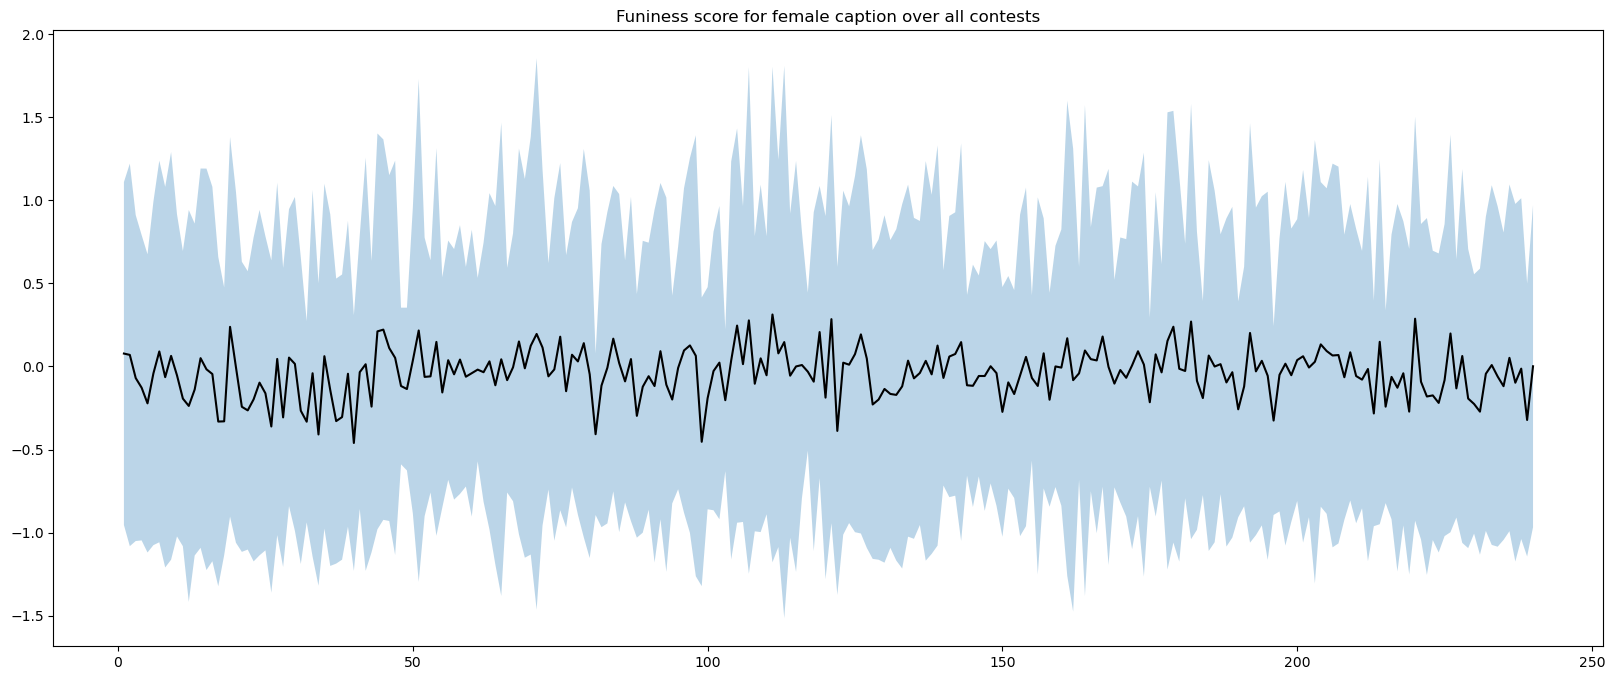

In [121]:
plt.figure(figsize=(20,8))
plt.fill_between(x=np.linspace(0, len(mean_funny_female), len(mean_funny_female)+1)[1:], y1=np.array(mean_funny_female)+np.array(std_funny_female), y2=np.array(mean_funny_female)-np.array(std_funny_female),
                 alpha = 0.3, linestyle = '--')
plt.plot(np.linspace(0, len(mean_funny_female), len(mean_funny_female)+1)[1:], mean_funny_female, color = 'black')
plt.title("Funiness score for female caption over all contests")

Text(0.5, 1.0, 'Funiness score for male caption over all contests')

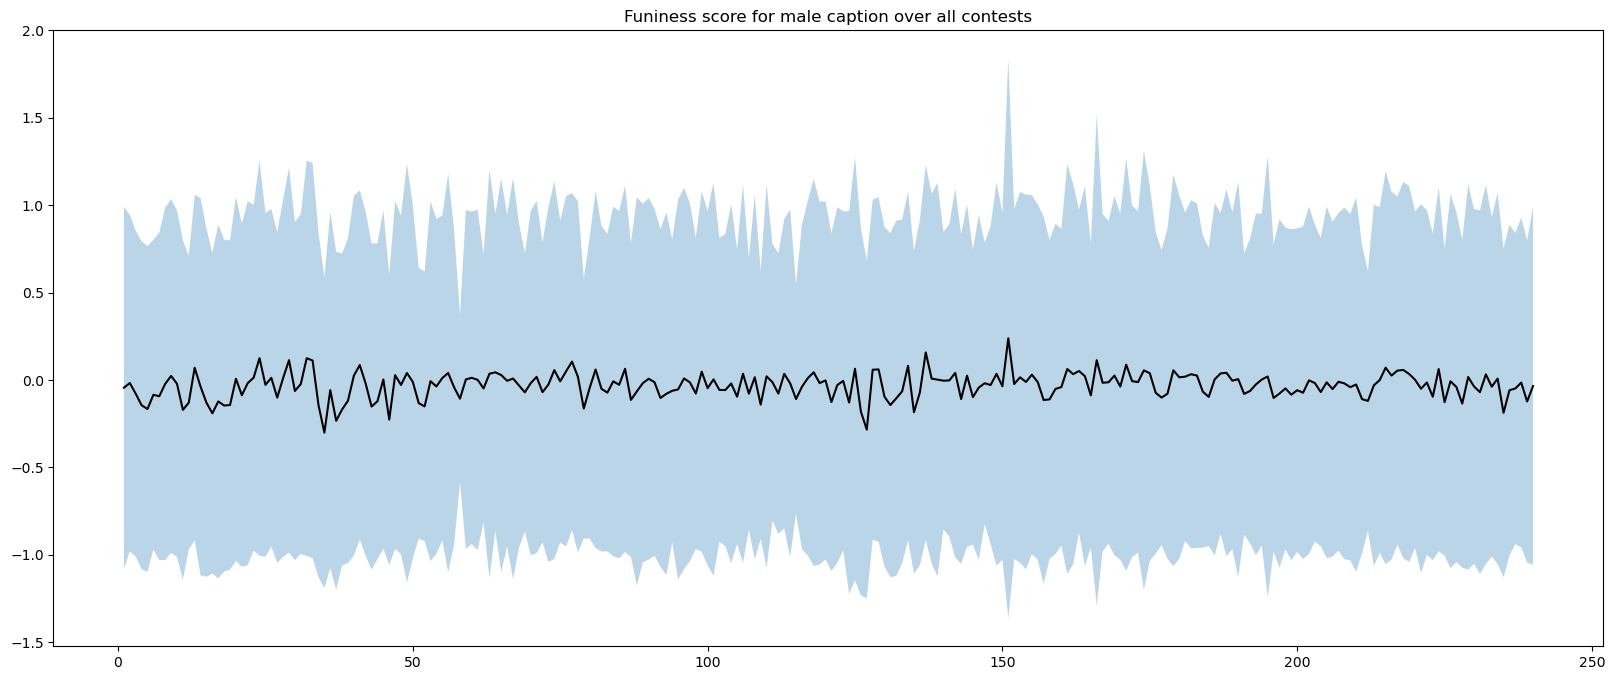

In [158]:
plt.figure(figsize=(20,8))
plt.fill_between(x=np.linspace(0, len(mean_funny_male), len(mean_funny_male)+1)[1:], y1=np.array(mean_funny_male)+np.array(std_funny_male), y2=np.array(mean_funny_male)-np.array(std_funny_male),
                 alpha = 0.3, linestyle = '--')
plt.plot(np.linspace(0, len(mean_funny_male), len(mean_funny_male)+1)[1:], mean_funny_male, color = 'black')
plt.title("Funiness score for male caption over all contests")

In [25]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

In [26]:
flatten_funny_male = flatten(list_funny_male)
flatten_funny_female = flatten(list_funny_female)

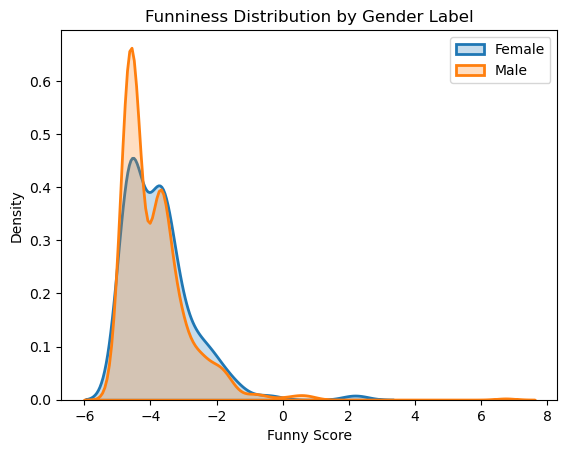

In [27]:
sns.kdeplot(flatten_funny_female[0], fill=True, label = 'Female', linewidth=2)
sns.kdeplot(flatten_funny_male[0], fill=True, label="Male", linewidth=2)

plt.title("Funniness Distribution by Gender Label")
plt.xlabel("Funny Score")
plt.legend()
plt.show()

Since the values of the funiness score vary a lot for each contest, we'll use statistical testing.

### Statistical testing

In [30]:
u_stat, p_value = mannwhitneyu(flatten_funny_female[0], flatten_funny_male[0], alternative="two-sided")
print("Mann-Whitney U:", u_stat)
print("p-value:", p_value)

Mann-Whitney U: 39666.5
p-value: 0.09654745396792908


## Other codes

In [23]:
male_terms = [
            'guy', 'spokesman', 'chairman', "men's", 'men', 'him', "he's", 'his', 'boy',
            'boyfriend', 'boyfriends', 'boys', 'brother', 'brothers', 'dad', 'dads',
            'dude', 'father', 'fathers', 'fiance', 'gentleman', 'gentlemen', 'god',
            'grandfather', 'grandpa', 'grandson', 'groom', 'he', 'himself', 'husband',
            'husbands', 'king', 'male', 'man', 'mr', 'nephew', 'nephews', 'priest',
            'prince', 'son', 'sons', 'uncle', 'uncles', 'waiter', 'widower', 'widowers',
            'congressman',

            # --- Added universal & contextual male terms ---
            'bloke', 'chap', 'fella', 'gent', 'sir', 'lad', 'lads',
            'manliness', 'masculine', 'boyhood',
            'father-in-law', 'stepfather', 'stepson',
            'godfather', 'old man',
            'bachelor', 'groomsman',
            'kings',
            'monk', 'wizard',
            'policeman', 'fireman', 'salesman', 'businessman', 'workman',

            # --- Public figures ---
            "bush", "sanders",
            "einstein", "hitchcock", "bansky", "kanye", "obama","biden","trump","putin","zelenskyy",
            "macron","schwarzenegger","clooney","hanks","dicaprio",
            "pitt","depp","cruise","stallone","eastwood","gosling","carey","seinfeld","rock","chappelle",
            "sandler","springsteen","dylan","cobain","mars","drake","sheeran","mccartney","lennon",
            "jagger","bale","damon","affleck","reynolds","washington","freeman","jackson","smith","murphy",
            "reeves","keaton","downey","ruffalo","leno","colbert","stewart","oppenheimer","gates","musk"


            # --- 200 Most Popular American male names ---
            "james","robert","john","michael","david","william","richard","joseph","thomas","charles",
            "christopher","daniel","matthew","anthony","mark","donald","steven","paul","andrew","joshua",
            "kenneth","kevin","brian","george","edward","ronald","timothy","jason","jeffrey","ryan",
            "jacob","gary","nicholas","eric","jonathan","stephen","larry","justin","scott","brandon",
            "benjamin","samuel","gregory","alexander","frank","patrick","raymond","jack","dennis","jerry",
            "tyler","aaron","jose","adam","nathan","henry","douglas","zachary","peter","kyle",
            "walter","ethan","jeremy","harold","keith","christian","roger","noah","gerald","carl",
            "terry","sean","austin","arthur","lawrence","jesse","dylan","bryan","joe","jordan",
            "billy","bruce","albert","willie","gabriel","logan","alan","juan","wayne","roy",
            "ralph","randy","eugene","vincent","bobby","russell","louis","philip","johnny","riley",
            "victor","mason","dale","brett","caleb","curtis","phillip","nathaniel","rodney","cody",
            "joel","craig","tony","evan","shawn","wesley","alex","travis","chad","derrick",
            "stanley","leonard","connor","oscar","xavier","miguel","edwin","martin","emmanuel","jay",
            "clifford","herman","seth","edgar","mario","frederick","allen","tyrone","max","aiden",
            "colton","hector","jon","spencer","rick","clarence","malik","leo","dustin","maurice",
            "dominic","hayden","troy","gordon","marshall","abel","andre","lawson","reed","ramon",
            "lance","casey","terrence","francis","trevor","jared","marco","darren","eli","ben",
            "rafael","don","diego","romeo","ruben","clayton","carlos","kirk","brayden","ronnie",
            "felix","jimmy","asher","camden","harvey","brendan","tristan","dean","parker","francisco",
            "ivan","milo","ted"
        ]

In [21]:
dataA[0]['caption'][3901]

"This has 'Alice in Wonderland' beat by a mile."

In [15]:
# load nlp from spacy
nlp = spacy.load("en_core_web_sm")

In [20]:
example = data_caption[0]['caption'].values[0]
example

"i'm a congressman--obstruction is my job."

In [21]:
example = data_caption[0]['caption'].values[0]
doc = nlp(example)

In [24]:
tokens = [token.text for token in doc]
print(tokens)

['This', 'has', "'", 'Alice', 'in', 'Wonderland', "'", 'beat', 'by', 'a', 'mile', '.']


In [25]:
pos_tagged = [(token.text, token.pos_) for token in doc]
print(pos_tagged)

[('This', 'PRON'), ('has', 'VERB'), ("'", 'PUNCT'), ('Alice', 'PROPN'), ('in', 'ADP'), ('Wonderland', 'PROPN'), ("'", 'PUNCT'), ('beat', 'NOUN'), ('by', 'ADP'), ('a', 'DET'), ('mile', 'NOUN'), ('.', 'PUNCT')]


In [26]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Alice PERSON
Wonderland GPE
a mile QUANTITY


In [ ]:
def extract_nouns(dataA):
    nlp = spacy.load("en_core_web_sm")
    nouns = Counter()

    for idx in range(len(dataA)):
        captions = dataA[idx].caption

    for text in captions:
        doc = nlp(text)
        for token in doc:
            if token.pos_ in ["NOUN"]:  # common + proper nouns
                nouns[token.lemma_] += 1
    return nouns

def extract_proper_nouns(dataA):

    nlp = spacy.load("en_core_web_sm")
    proper_nouns = Counter()

    for idx in range(len(dataA)):
        captions = dataA[idx].caption

        for text in captions:
            doc = nlp(text)
            for ent in doc.ents:
                if ent.label_ == 'PERSON':
                    proper_nouns[ent.text] += 1

    return proper_nouns

In [61]:
# load nlp from spacy
nlp = spacy.load("en_core_web_sm")

verbs_male = []
verbs_female = []
adjs_male = []
adjs_female = []

# Create two separated document: one with all the male and the other with all of the female captions
for contest in data_caption:
    # initialize lists that keep track of type of words
    verb_male = []
    verb_female = []
    adj_male = []
    adj_female = []


    # find in each caption that are labeled as male the verb and ajdectives
    male_captions = contest[contest['gender_mention'] == 'male'].caption.values
    for caption in male_captions:
        doc = nlp(caption)
        for token in doc:
            if token.pos_ == 'VERB':
                verb_male.append(token.text)
            elif token.pos_ == 'ADJ':
                adj_male.append(token.text)


    # find in each caption that are labeled as female the verb and ajdectives
    female_captions = contest[contest['gender_mention'] == 'female'].caption.values
    for caption in female_captions:
        doc = nlp(caption)
        for token in doc:
            if token.pos_ == 'VERB':
                verb_female.append(token.text)
            elif token.pos_ == 'ADJ':
                adj_female.append(token.text)

    
    verbs_male.append(verb_male)
    verbs_female.append(verb_female)
    adjs_male.append(adj_male)
    adjs_female.append(adj_female)
    break

In [ ]:
## LDA Model -> UNSTABLE    

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import re

# Download NLTK stopwords
# nltk.download('stopwords')
stop_words = stopwords.words('english')

# Load data
data = pd.read_csv('all_caption_female.csv')

# Preprocess the text data
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\S*@\S*\s?', '', text)  # Remove emails
    text = re.sub('\'', '', text)  # Remove apostrophes
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabet characters
    text = text.lower()  # Convert to lowercase
    return text

# Tokenize and remove stopwords
def tokenize(text):
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

def lemmatize(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

data['cleaned_text'] = data['caption'].apply(preprocess_text) 
data['tokens'] = data['cleaned_text'].apply(tokenize)

# Lemmatization using spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data['lemmas'] = data['tokens'].apply(lemmatize)

# Create dictionary and corpus
id2word = corpora.Dictionary(data['lemmas'])
texts = data['lemmas']
corpus = [id2word.doc2bow(text) for text in texts]

Number of topics: 6.0
Number of topics: 7.0
Number of topics: 8.0
Number of topics: 9.0
Number of topics: 10.0
Number of topics: 11.0
Number of topics: 12.0
Number of topics: 13.0
Number of topics: 14.0
Number of topics: 15.0
Number of topics: 16.0
Number of topics: 17.0
Number of topics: 18.0
Number of topics: 19.0
Number of topics: 20.0


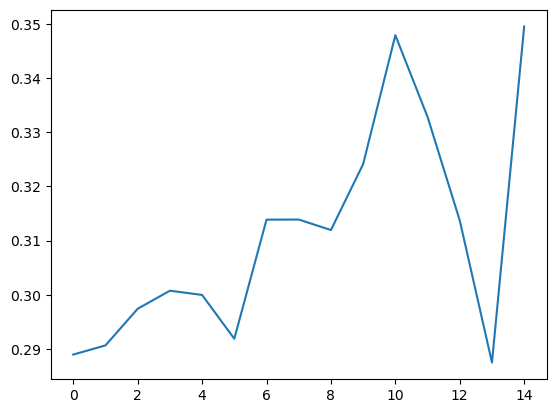

In [ ]:
num_topics_list = np.linspace(6, 20, 15)

coherence_score = []

for i in num_topics_list:
    print(f"Number of topics: {i}")
    # Build LDA model, NUMBER OF TOPICS: pick the one that has the highest coherence score.
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=i, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)

    # Print the topics
    # topics = lda_model.print_topics(num_words=5)
    # for topic in topics:
    #     print(topic)

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data['lemmas'], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

plt.plot(coherence_score)

In [59]:
# ## From the exercices

# analyzer = SentimentIntensityAnalyzer()
# vs = analyzer.polarity_scores(example)

# print(example, '\n')
# print('Negative sentiment:',vs['neg'])
# print('Neutral sentiment:',vs['neu'])
# print('Positive sentiment:',vs['pos'])
# print('Compound sentiment:',vs['compound'])

# nlp = spacy.load('en_core_web_sm')
# doc = nlp(books[3])

# positive_sent = []
# #iterate through the sentences, get polarity scores, choose a value
# [positive_sent.append(analyzer.polarity_scores(sent.text)['pos']) for sent in doc.sents]
# plt.hist(positive_sent,bins=15)
# plt.xlim([0,1])
# plt.ylim([0,8000])
# plt.xlabel('Positive sentiment')
# plt.ylabel('Number of sentences')

# negative_sent = []
# [negative_sent.append(analyzer.polarity_scores(sent.text)['neg']) for sent in doc.sents]
# plt.hist(negative_sent,bins=15)
# plt.xlim([0,1])
# plt.ylim([0,8000])
# plt.xlabel('Negative sentiment')
# plt.ylabel('Number of sentences')

# total_sent = []
# [total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in doc.sents]
# plt.hist(total_sent,bins = 15)
# plt.xlim([-1,1])
# plt.ylim([0,8000])
# plt.xlabel('Compound sentiment')
# plt.ylabel('Number of sentences')

# sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in doc.sents]
# print('Number of positive sentences:',sum(np.array(sents)>=0.05))
# print('Number of negative sentences:',sum(np.array(sents)<=-0.05))
# print('Number of neutral sentences:',sum(np.abs(np.array(sents))<0.05))